Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import warnings


warnings.filterwarnings('ignore')


Load & preprocessing data

In [2]:
data = pd.read_csv('cc_approvals.data')

# no header included in the data
data.columns = ['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 
           'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 
           'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'ApprovalStatus']

print(data.head())

  Gender    Age   Debt Married BankCustomer EducationLevel Ethnicity  \
0      a  58.67  4.460       u            g              q         h   
1      a  24.50  0.500       u            g              q         h   
2      b  27.83  1.540       u            g              w         v   
3      b  20.17  5.625       u            g              w         v   
4      b  32.08  4.000       u            g              m         v   

   YearsEmployed PriorDefault Employed  CreditScore DriversLicense Citizen  \
0           3.04            t        t            6              f       g   
1           1.50            t        f            0              f       g   
2           3.75            t        t            5              t       g   
3           1.71            t        f            0              f       s   
4           2.50            t        f            0              t       g   

  ZipCode  Income ApprovalStatus  
0   00043     560              +  
1   00280     824           

In [3]:
df = pd.DataFrame(data)

# one-hot encoding
label_encoders = {}

for column in df.select_dtypes(include=['object']).columns: # select only 'object' type columns - excluding int and float
   label_encoders[column] = LabelEncoder()
   df[column] = label_encoders[column].fit_transform(df[column])

# split features and label
X = df.drop('ApprovalStatus', axis=1)
Y = df['ApprovalStatus']  

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)    

Load & train models

In [4]:
#load models
log_model = SGDClassifier(loss='log_loss', max_iter=500, tol=1e-2, 
                          random_state=42, alpha=1, penalty='elasticnet', l1_ratio=0.2,
                          early_stopping=True, validation_fraction=0.1
                          , learning_rate='adaptive', eta0=0.012)
nb_model = GaussianNB()

log_model.fit(x_train, y_train)
nb_model.fit(x_train, y_train)

log_y_pred = log_model.predict(x_test)
nb_y_pred = nb_model.predict(x_test)

w0 = log_model.intercept_
w1 = log_model.coef_[0]

w = np.concatenate((w0.reshape(1,1), w1.reshape(1,15)), axis=1).flatten()
print('Logistic Regression parameter vector:', ' '.join([f'{val:.2f}' for val in w]))



Logistic Regression parameter vector: 3.20 0.00 -0.01 0.00 0.00 0.00 0.00 0.00 -0.17 0.00 0.00 -0.14 0.00 0.00 0.00 -0.00


Compare training vs test dataset

In [5]:
log_y_pred_train = log_model.predict(x_train)
# accuracy
log_acc_train = accuracy_score(y_train, log_y_pred_train)
log_acc_test = accuracy_score(y_test, log_y_pred)

# precision
log_precision_train = precision_score(y_train, log_y_pred_train)
log_precision_test = precision_score(y_test, log_y_pred)

# recall
log_recall_train = recall_score(y_train, log_y_pred_train)
log_recall_test = recall_score(y_test, log_y_pred)

# f1 score
log_f1_train = f1_score(y_train, log_y_pred_train)
log_f1_test = f1_score(y_test, log_y_pred)

# confusion matrix
log_cm_train = confusion_matrix(y_train, log_y_pred_train)
log_cm_test = confusion_matrix(y_test, log_y_pred)

# selectivity
log_selectivity_train = log_cm_train[0][0] / (log_cm_train[0][0] + log_cm_train[1][0])
log_selectivity_test = log_cm_test[0][0] / (log_cm_test[0][0] + log_cm_test[1][0])

# log loss - need to use predict_proba
log_proba_train = log_model.predict_proba(x_train)
log_proba_test = log_model.predict_proba(x_test)
log_log_loss_train = log_loss(y_train, log_proba_train)
log_log_loss_test = log_loss(y_test, log_proba_test)




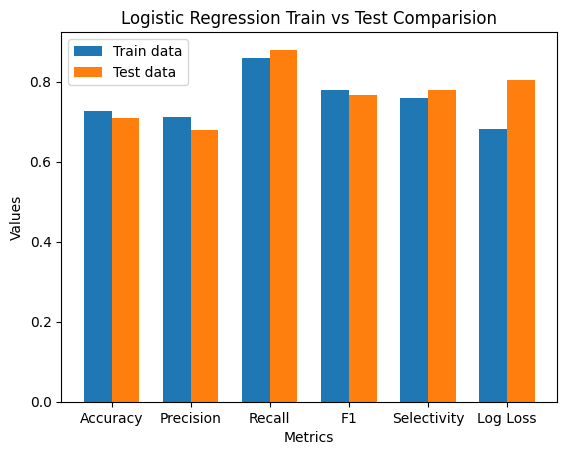

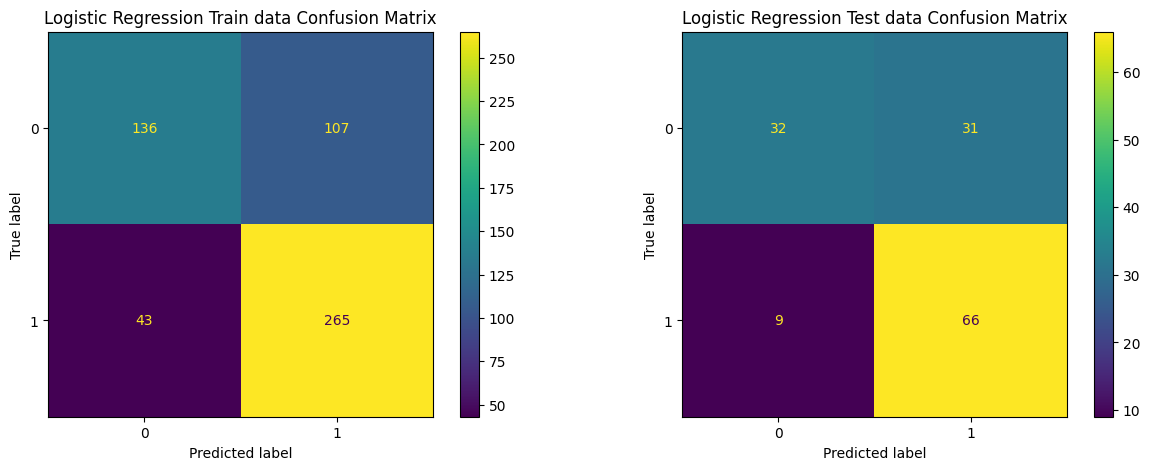

In [6]:
# plot bar chart compare metrics
log_train_metrics = [log_acc_train, log_precision_train, log_recall_train, log_f1_train, log_selectivity_train, log_log_loss_train]
log_test_metrics = [log_acc_test, log_precision_test, log_recall_test, log_f1_test, log_selectivity_test, log_log_loss_test]

bar_width = 0.35
n_metrics = len(log_train_metrics)
index = np.arange(n_metrics)

fig, ax = plt.subplots()

bar1 = ax.bar(index, log_train_metrics, bar_width, label='Train data')
bar2 = ax.bar(index + bar_width, log_test_metrics, bar_width, label='Test data')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Logistic Regression Train vs Test Comparision')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Accuracy', 'Precision', 'Recall', 'F1', 'Selectivity', 'Log Loss'))
ax.legend()


#plot confusion matrixes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ConfusionMatrixDisplay(log_cm_train, display_labels=log_model.classes_).plot(ax=ax1)
ax1.set_title('Logistic Regression Train data Confusion Matrix')

ConfusionMatrixDisplay(log_cm_test, display_labels=nb_model.classes_).plot(ax=ax2)
ax2.set_title('Logistic Regression Test data Confusion Matrix')
plt.show()

Compare to GaussainNB model

In [7]:
# accuracy
log_acc = accuracy_score(y_test, log_y_pred)
nb_acc = accuracy_score(y_test, nb_y_pred)

# precision
log_precision = precision_score(y_test, log_y_pred)
nb_precision = precision_score(y_test, nb_y_pred)

# recall
log_recall = recall_score(y_test, log_y_pred)
nb_recall = recall_score(y_test, nb_y_pred)

# f1 score
log_f1 = f1_score(y_test, log_y_pred)
nb_f1 = f1_score(y_test, nb_y_pred)

# confusion matrix
log_cm = confusion_matrix(y_test, log_y_pred)
nb_cm = confusion_matrix(y_test, nb_y_pred)

# selectivity
log_selectivity = log_cm[0][0] / (log_cm[0][0] + log_cm[1][0])
nb_selectivity = nb_cm[0][0] / (nb_cm[0][0] + nb_cm[1][0])

# log loss - need to use predict_proba
log_proba = log_model.predict_proba(x_test)
nb_proba = nb_model.predict_proba(x_test)
log_log_loss = log_loss(y_test, log_proba)
nb_loss = log_loss(y_test, nb_proba)



Plotting charts

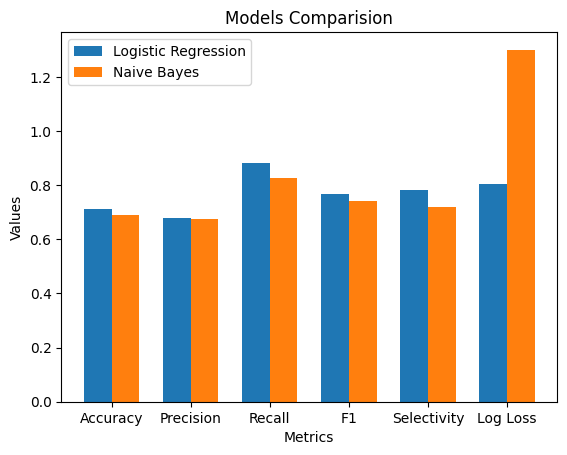

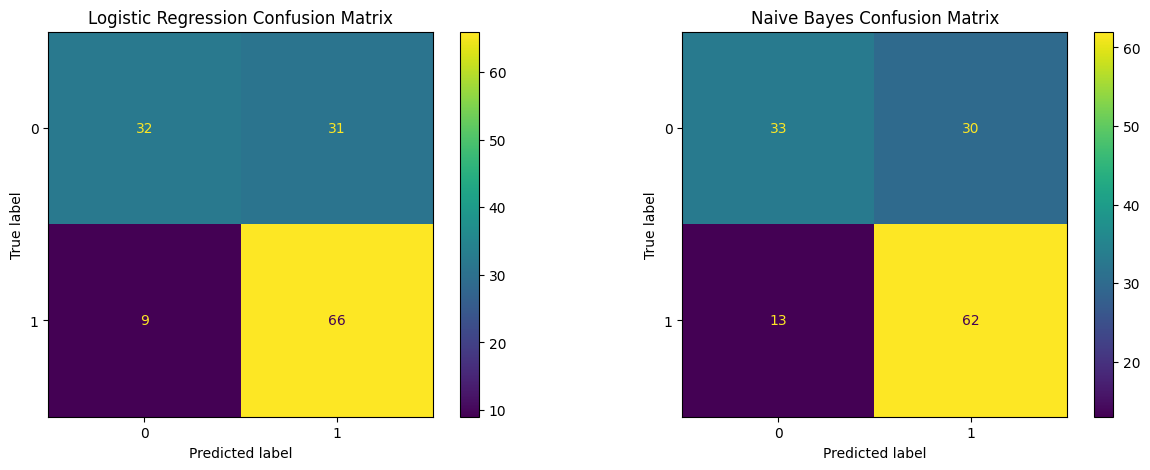

In [8]:
# plot bar chart compare metrics
log_metrics = [log_acc, log_precision, log_recall, log_f1, log_selectivity, log_log_loss]
nb_metrics = [nb_acc, nb_precision, nb_recall, nb_f1, nb_selectivity, nb_loss]

bar_width = 0.35
n_metrics = len(log_metrics)
index = np.arange(n_metrics)

fig, ax = plt.subplots()

bar1 = ax.bar(index, log_metrics, bar_width, label='Logistic Regression')
bar2 = ax.bar(index + bar_width, nb_metrics, bar_width, label='Naive Bayes')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Models Comparision')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Accuracy', 'Precision', 'Recall', 'F1', 'Selectivity', 'Log Loss'))
ax.legend()


#plot confusion matrixes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ConfusionMatrixDisplay(log_cm, display_labels=log_model.classes_).plot(ax=ax1)
ax1.set_title('Logistic Regression Confusion Matrix')

ConfusionMatrixDisplay(nb_cm, display_labels=nb_model.classes_).plot(ax=ax2)
ax2.set_title('Naive Bayes Confusion Matrix')
plt.show()